# Discovery of Writing Differences - Neural Networks Representation

Capstone project by Tomo Umer

<img src="https://tomoumerdotcom.files.wordpress.com/2022/04/cropped-pho_logo_notext.png" alt="PRAISE DOG" style="width:400px;height:400px;"/>

## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import glob
import plotly.express as px
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MaxAbsScaler
from copy import deepcopy

import umap
from scipy import spatial
from scipy.cluster.hierarchy import linkage, dendrogram

from joblib import dump, load

## Reading In the Library and Prep for NN

In this part, reading the .pkl file. 

In [2]:
library_select = pd.read_pickle('../data/library_select02.pkl')

In [3]:
library_select.shape

(538, 12)

Next, extract authors, create dictionary to convert authors name to numeric values (for predictions) and add a column with that.

In [4]:
select_authors = list(library_select.sort_values(by='authorcentury')['author'].unique())

authors_to_num = {select_authors[i]: i for i in range(len(select_authors))}
#num_to_authors = {v: k for k, v in authors_to_num.items()}

library_select['author_num'] = library_select['author'].map(authors_to_num)

## Sklearn NN

First round of neural network analysis, using sklearn.

In [5]:
X = library_select[['book_content']]
y = library_select['author_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [6]:
library_select.shape

(538, 13)

In [7]:
pipe_nn = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
        ('scaler', MaxAbsScaler()),  #this is needed in order to make it converge in a reasonable time!
        ('nn', MLPClassifier(verbose = True,
                             hidden_layer_sizes = (100, 100),
                             #activation = 'relu',
                             #max_iter = 10000,
                             #alpha=0.05
                             ))
    ]
)

In [ ]:
# pipe_nn.fit(X_train['book_content'], y_train)
# y_pred = pipe_nn.predict(X_test['book_content'])

# print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
# print('----- confusion matrix ------')
# print(confusion_matrix(y_test, y_pred), '\n')
# print('-------- classification report ---------')
# print(classification_report(y_test, y_pred))

# this below ran for almost 2 hours and didn't finish yet...
pipe_nn.fit(X['book_content'], y)
y_pred = pipe_nn.predict(X['book_content'])

print('accuracy score:', accuracy_score(y, y_pred), '\n')
print('----- confusion matrix ------')
print(confusion_matrix(y, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y, y_pred))

In [ ]:
fig = px.imshow(confusion_matrix(y, pipe_nn.predict(X['book_content'])),
                width=1000,
                height=800,
                text_auto=True,
                labels=dict(x='Predicted Label',
                            y='True Label'),
                            x=select_authors,
                            y=select_authors,
                            color_continuous_scale='Teal'
                            )

fig.update(layout_coloraxis_showscale=False)

fig.show()

## Encoding and lower-dimensional representation of the NN

With a trained model, using embeddings to find similarities between books and authors.

In [ ]:
# have to use the regressor because classifiers thinks we're expecting int results, even if we chop it off before final step!
# :2 and layers = 3 if I use two hidden layers with nn; for one, reduce those by 1
encoder = MLPRegressor()
encoder.coefs_ = pipe_nn['nn'].coefs_[:2]
encoder.intercepts_ = pipe_nn['nn'].intercepts_[:2]
encoder.n_layers_ = 3
encoder.out_activation_ = 'relu'

In [ ]:
# copy the pipeline
pipe_nn_encoder = deepcopy(pipe_nn)

# remove the classifier
pipe_nn_encoder.steps.pop(2)

# append the new encoder (essentially, it contains all layers minus the final one)
pipe_nn_encoder.steps.append(['enc', encoder])

In [9]:
# now using predict from the encoder to get the 100-dimensional projection of the top six authors
nn_represent = pipe_nn_encoder.predict(library_select['book_content'])

In [ ]:
# to save the encoder
# dump(pipe_nn_encoder, '../models/pipe_nn_encoder_01.joblib')
#dump(pipe_nn_encoder, '../models/pipe_nn_encoder_02.joblib')

Finally, adding to that, the reduced 2D representation using UMAP.

In [39]:
umap_mnist = umap.UMAP(metric='euclidean', random_state=42) #metric = 'cosine'
umap_mnist.fit(nn_represent)

umap_projection = umap_mnist.transform(nn_represent)

In [ ]:
# to save the umap representation
# dump(umap_mnist, '../models/umap_mnist_01.joblib')
#dump(umap_mnist, '../models/umap_mnist_02.joblib')

In [40]:
# convert the 100 dimensional vector of neuron weights into dataframe
library_select_represent = pd.DataFrame(nn_represent, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
library_select_proj = pd.DataFrame(umap_projection, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
library_select = pd.concat([
    library_select[['id','title','author','authorcentury']],
    library_select_proj.set_index(library_select.index),
    library_select_represent.set_index(library_select.index)],
    axis=1)

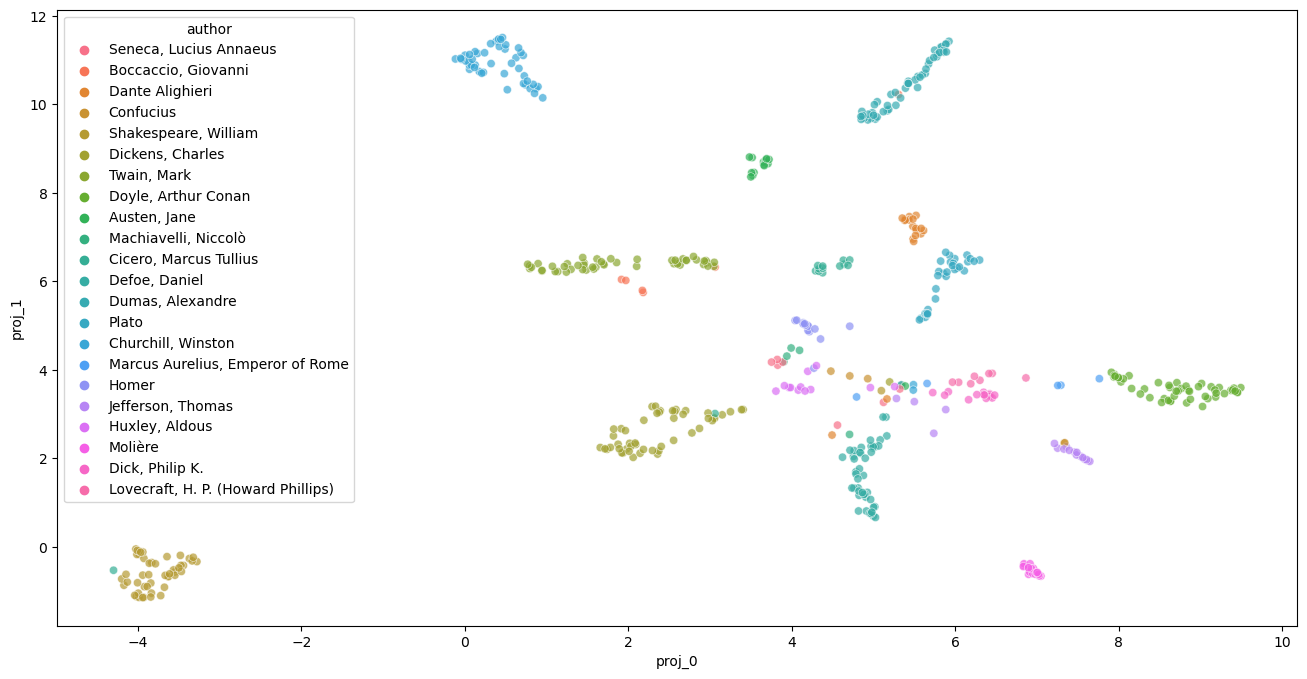

In [41]:
# # old code:
# sns.scatterplot(x=umap_projection[:,0], y=umap_projection[:,1], 
#                 hue = library_select.replace({'author': num_to_authors})['author'].astype('category'),
#                alpha = 0.7);

plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = 'author',
               alpha = 0.7);

In [42]:
library_select['authorcentury'].unique()

array([ 1., 14., 13., -6., 16., 19., 18., 15., -1., -4., 20.,  2., -7.,
       17.])

In [78]:
def annotate_century(num_century):

    if np.isnan(num_century):
        return 'unknown'
    elif int(num_century) < 0 :
        ctry = ' century BCE'
        num_century = abs(int(num_century))
    else:
        num_century = int(num_century)
        ctry = ' century CE'


    # determine ordinal numbering
    if (num_century % 10 == 1) and (num_century % 100 != 11):
        ordinal_century = str(num_century) + 'st'

    elif (num_century % 10 == 2) and (num_century % 100 != 12):
        ordinal_century = str(num_century) + 'nd'

    elif (num_century % 10 == 3) and (num_century % 100 != 13):
        ordinal_century = str(num_century) + 'rd'
        
    else:
        ordinal_century = str(num_century) + 'th'

    return ordinal_century + ctry

In [80]:
library_select['authorcentury'] = library_select['authorcentury'].apply(annotate_century)

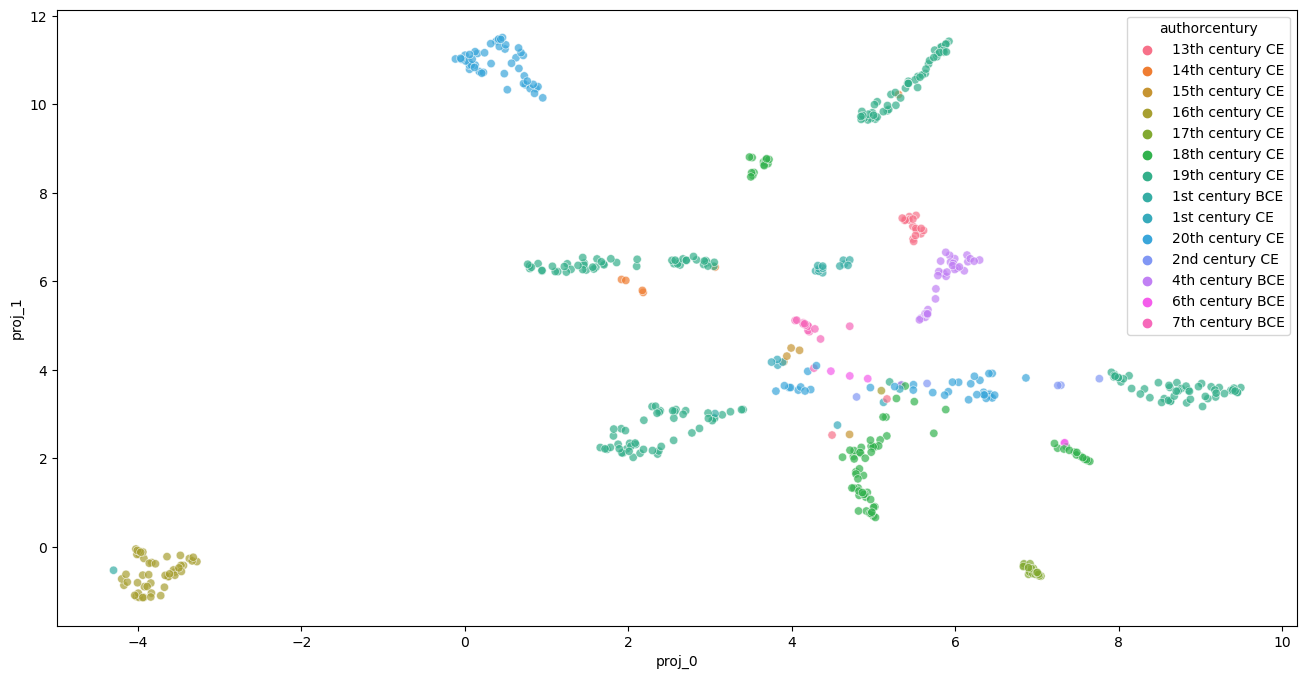

In [81]:
plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = library_select['authorcentury'].astype('category'),
               alpha = 0.7);

In [44]:
# make a copy -- personal note: important to use copy!! otherwise, it's just a view of the original dataframe 
# and that gives warnings in the following two parts
library_2d_dist = library_select[['author', 'proj_0', 'proj_1']].copy()

# calculate the mean point for each author
library_2d_dist[['proj_0_mean', 'proj_1_mean']] = library_2d_dist.groupby('author')[['proj_0', 'proj_1']].transform('mean')

# get the distance between each point and the mean for that author
library_2d_dist['dist_mean'] = np.sqrt((library_2d_dist['proj_0'] - library_2d_dist['proj_0_mean'])**2 + (library_2d_dist['proj_1'] - library_2d_dist['proj_1_mean'])**2)



In [45]:
library_2d_dist

,author,proj_0,proj_1,proj_0_mean,proj_1_mean,dist_mean
1,"Seneca, Lucius Annaeus",5.122746,3.262436,4.328088,3.749846,0.932228
6,"Boccaccio, Giovanni",3.062505,6.319431,2.768120,6.688782,0.472316
21,Dante Alighieri,5.580406,7.071321,5.412542,6.792332,0.325597
32,Dante Alighieri,5.613077,7.145921,5.412542,6.792332,0.406496
43,Dante Alighieri,5.482569,7.240213,5.412542,6.792332,0.453323
...,...,...,...,...,...,...
70047,"Dickens, Charles",2.185338,2.197886,2.425765,2.629600,0.494147
70069,"Dumas, Alexandre",4.847382,9.721254,5.403183,10.451133,0.917408
70091,"Dickens, Charles",2.009201,2.156166,2.425765,2.629600,0.630607
70102,"Dickens, Charles",2.402548,2.265109,2.425765,2.629600,0.365229


In [46]:
library_2d_dist['dist_mean'].describe()

count    538.000000
mean       0.655187
std        0.901212
min        0.014475
25%        0.299578
50%        0.530392
75%        0.740770
max       10.117242
Name: dist_mean, dtype: float64

In [47]:
dist2d_mean = library_2d_dist['dist_mean'].mean()

## Similarity using spatial distance in 100 dimension

Another way to look at the produced weights and which ones are similar

Calculating cosine similarity (using dim_0 to dim_99 cols) - for a first attempt, group it by author.

In [48]:
# idea use this to transpose and then see the dist from each book to this point?
library_select_grouped = library_select.drop(columns=['id','title','authorcentury','proj_0','proj_1']).groupby('author').mean()

In [49]:
dists = spatial.distance.pdist(library_select_grouped.values, metric='euclidean') # metric='cosine'

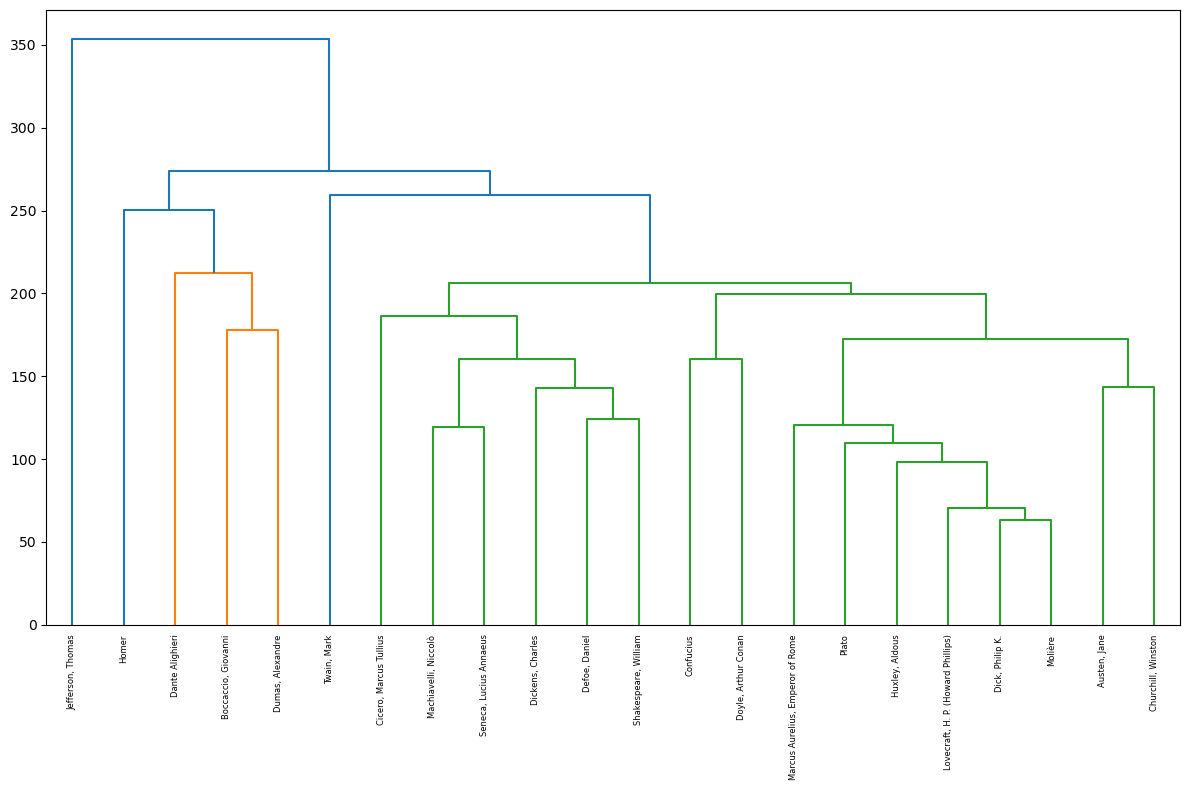

In [50]:
mergings = linkage(dists, method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(library_select_grouped.index),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()

In [22]:
# before I realized to use this approach, I first concatenated all the texts in the pandas series which returns an extremely long string
# I then turn that string into a pandas series (the predict requires an iterable object)
# pipe_nn.predict(pd.Series(library_select.loc[library_select['author'] == 0]['book_content'].str.cat()))

## Introducing New Text

This part will ideally be in an app where any text can be uploaded

Here I will test it with two books I've written.

In [23]:
# if the model was not run above, this is where we load the encoder and the umamp_mnist
#pipe_nn_encoder = load('../models/pipe_nn_encoder_02.joblib') 
#umap_mnist = load('../models/umap_mnist_02.joblib')

In [51]:
newtext = pd.DataFrame()

for book_num, book_name in enumerate(['Lambda', 'Deathway']):
        filepath = f'../data/{book_name} by Tomo Umer.txt'

        with open(filepath, encoding = 'utf-8') as fi:
                book = fi.read()
        
        tmp_text = pd.DataFrame({'id': f'TU{str(book_num).zfill(3)}',
                                 'title': [book_name],
                                 'author': 'Umer, Tomo',
                                 'authorcentury': 21,
                                 'book_content': [book]})

        newtext = pd.concat([newtext, tmp_text], ignore_index = True)

In [52]:
newtext

,id,title,author,authorcentury,book_content
0,TU000,Lambda,"Umer, Tomo",21,Lambda\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1,TU001,Deathway,"Umer, Tomo",21,DeathwayIndex\nIntroduction\nMy second novel! ...


In [82]:
newtext['authorcentury'] = newtext['authorcentury'].apply(annotate_century)

As a reminder (to myself), in order to convert the new texts, we only need predict and transform methods

In [83]:
# now using predict from the encoder to get the 100-dimensional projection of new text
nn_represent_newtext = pipe_nn_encoder.predict(newtext['book_content'])

# and its 2d representation using umap
umap_projection_newtext = umap_mnist.transform(nn_represent_newtext)

KeyError: 'book_content'

In [ ]:
# and then just like with the authors, convert new texts into a dataframe
# convert the 100 dimensional vector of neuron weights into dataframe
newtxt_represent = pd.DataFrame(nn_represent_newtext, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
newtxt_proj = pd.DataFrame(umap_projection_newtext, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
newtext = pd.concat([
    newtext[['id','title','author','authorcentury']],
    newtxt_proj.set_index(newtext.index),
    newtxt_represent.set_index(newtext.index)],
    axis=1)

Then, use the median 0.549409 (or possibly mean 0.721832) value to get a circle around the new texts - to visually represent similar books.

In [85]:
circle_edges = newtext[['proj_0', 'proj_1']].copy()

In [86]:
circle_edges['x0'] = circle_edges['proj_0'] - dist2d_mean
circle_edges['x1'] = circle_edges['proj_0'] + dist2d_mean
circle_edges['y0'] = circle_edges['proj_1'] - dist2d_mean
circle_edges['y1'] = circle_edges['proj_1'] + dist2d_mean

In [87]:
circle_edges

,proj_0,proj_1,x0,x1,y0,y1
0,4.88260,2.497329,4.227414,5.537787,1.842142,3.152516
1,3.73109,3.041981,3.075903,4.386276,2.386794,3.697167


Finally, simply add the new text to the library.

In [88]:
library_newtext = pd.concat([library_select, newtext])

In [89]:
fig = px.scatter(data_frame = library_newtext,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= 'author',
                 color_discrete_sequence=px.colors.qualitative.Alphabet, #Dark24
                 hover_data= ['title']
                 )

for i in range(circle_edges.shape[0]):
    fig.add_shape(type='circle',
        xref='x', yref='y',
        x0=circle_edges['x0'][i],
        y0=circle_edges['y0'][i],
        x1=circle_edges['x1'][i],
        y1=circle_edges['y1'][i],
        line_color='LightSeaGreen',
    )


fig.show()

In [90]:
fig = px.scatter(data_frame = library_newtext,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= library_newtext['authorcentury'].astype('category'),
                 color_discrete_sequence=px.colors.qualitative.Alphabet, #Dark24
                 hover_data= ['title']
                 )

fig.show()

In [66]:
dists = spatial.distance.pdist(library_newtext.drop(columns=['id', 'title', 'author', 'authorcentury', 'proj_0', 'proj_1']).values,  metric='euclidean') #metric = 'cosine'

In [77]:
np.mean(dists)

259.65915894234223

note: to find out the dist between two authors, need to get the correct index for dist.

for i < j < m (where m = num of authors):

index = m * i + j - ((i + 2) * (i + 1)) // 2

dists[index]

For Lambda, cosine distance:

In [67]:
m = library_newtext.shape[0]
j = m-2

cos_dist = []
titles = []
authors = []

for i in range(j):
    titles.append(library_newtext['title'].iloc[i])
    authors.append(library_newtext['author'].iloc[i])
    cos_dist.append(dists[m * i + j - ((i + 2) * (i + 1)) // 2])

In [68]:
pd.concat([pd.DataFrame({'title':titles}),
           pd.DataFrame({'author':authors}),
           pd.DataFrame({'Deathway':cos_dist})],
           axis=1).sort_values(by='Deathway', ascending=True).head(10)

,title,author,Deathway
155,"Dickory Cronke: The Dumb Philosopher, or, Grea...","Defoe, Daniel",64.580838
426,"The Friendly Daemon, or the Generous Apparitio...","Defoe, Daniel",67.806888
289,"Augusta Triumphans: Or, the Way to Make London...","Defoe, Daniel",68.956168
534,The Black Tulip,"Dumas, Alexandre",70.562467
56,The History of the Remarkable Life of John She...,"Defoe, Daniel",70.836092
459,King Leopold's Soliloquy: A Defense of His Con...,"Twain, Mark",71.016953
288,Second Thoughts are Best: Or a Further Improve...,"Defoe, Daniel",71.269292
309,And What if the Pretender should Come?: Or Som...,"Defoe, Daniel",72.189738
156,"Everybody's Business Is Nobody's Business: Or,...","Defoe, Daniel",72.516219
305,Reasons Against the Succession of the House of...,"Defoe, Daniel",72.768133


For Deathway, cosine distance:

In [69]:
m = library_newtext.shape[0]
j = m-1

cos_dist = []
titles = []
authors = []

for i in range(j):
    titles.append(library_newtext['title'].iloc[i])
    authors.append(library_newtext['author'].iloc[i])
    cos_dist.append(dists[m * i + j - ((i + 2) * (i + 1)) // 2])

In [76]:
# Lambda is of course the most similar ... if wanted, simply do a .drop(538) on all 3 dataframes
pd.concat([pd.DataFrame({'title':titles}),
           pd.DataFrame({'author':authors}),
           pd.DataFrame({'Deathway':cos_dist})],
           axis=1).sort_values(by='Deathway', ascending=True).head(20)

,title,author,Deathway
338,The Storm. An Essay.,"Defoe, Daniel",41.200271
426,"The Friendly Daemon, or the Generous Apparitio...","Defoe, Daniel",41.695747
530,To Be Read at Dusk,"Dickens, Charles",42.434961
482,Mr. Keegan's Elopement,"Churchill, Winston",44.208322
304,A True Relation of the Apparition of one Mrs. ...,"Defoe, Daniel",44.237304
265,A Dog's Tale,"Twain, Mark",46.339217
58,A Message from the Sea,"Dickens, Charles",46.601563
144,"Extracts from Adam's Diary, translated from th...","Twain, Mark",46.861355
198,On the Decay of the Art of Lying,"Twain, Mark",47.461231
178,The Magic Fishbone: A Holiday Romance from the...,"Dickens, Charles",47.957887
